# Spaceship Titanic Dataset with TensorFlow Decision Forests

# Import the libraries

In [1]:
!pip install -Uq fastbook

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fastbook
fastbook.setup_book()

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from fastai import *
from fastai.tabular import *
from fastai.metrics import *
from fastai.tabular.all import *

# Load the Dataset

In [4]:
#train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
df = pd.read_csv("../input/spaceship-titanic/train.csv")

In [5]:
#df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
#df = train_df
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

# Prepare the dataset

In [6]:
warnings.filterwarnings('ignore')
#Get the group from the passenger ID
df[["passenger_id", "group_id"]] = df["PassengerId"].str.split("_", expand=True)
#fill blank values
df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
#change dtypes
df['VIP'] = df['VIP'].astype(int)
df['CryoSleep'] = df['CryoSleep'].astype(int)
#split cabin/number/side
df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
#change category dtypes
df['HomePlanet'] = df['HomePlanet'].astype('category')
df['Destination'] = df['Destination'].astype('category')
df['Side'] = df['Side'].astype('category')
df['Deck'] = df['Deck'].astype('category')
df['CryoSleep'] = df['CryoSleep'].astype('category')
df['VIP'] = df['VIP'].astype('category')
df['group_id'] = df['group_id'].astype('category')
#convert labels to numbers
df['HomePlanet'] = df['HomePlanet'].map( {'Earth': 0, 'Europa': 1, 'Mars': 2} )
df['Destination'] = df['Destination'].map( {'55 Cancri e': 0, 'PSO J318.5-22': 1, 'TRAPPIST-1e': 2} )
df['Deck'] = df['Deck'].map( {'A' : 0,'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7})
df['Side'] = df['Side'].map( {'P' : 0,'S' : 1})
#normalise numeric values
age_avg = df['Age'].mean()
age_std = df['Age'].std()
df.fillna({'Age': np.random.randint(age_avg - age_std, age_avg + age_std)}, inplace=True)
df['age_value']=df['Age']/50
df['RoomService'].fillna(np.mean(df['RoomService']), inplace=True)
df['RoomService_value']=df['RoomService']/50
df['FoodCourt'].fillna(np.mean(df['FoodCourt']), inplace=True)
df['FoodCourt_value']=df['FoodCourt']/50
df['ShoppingMall'].fillna(np.mean(df['ShoppingMall']), inplace=True)
df['ShoppingMall_value']=df['ShoppingMall']/50
df['Spa'].fillna(np.mean(df['Spa']), inplace=True)
df['Spa_value']=df['Spa']/50
df['VRDeck'].fillna(np.mean(df['VRDeck']), inplace=True)
df['VRDeck_value']=df['VRDeck']/50
#scale the normalized values
scale_cols = ["age_value", "RoomService_value", "FoodCourt_value", "ShoppingMall_value", "Spa_value", "VRDeck_value"]  
scale = MinMaxScaler()
df[scale_cols] = scale.fit_transform(df[scale_cols])
#drop the unwanted columns
delete_df_columns = ['PassengerId', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService', 'Age', 'VRDeck', 'Name', 'passenger_id', 'Cabin', 'Cabin_num']
df.drop(delete_df_columns, axis=1, inplace=True)
#one-hot encode categories
df = pd.get_dummies(df, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'group_id', 'Deck', 'Side'], dtype=int)
#view results
df.head(5)

,Transported,age_value,RoomService_value,FoodCourt_value,ShoppingMall_value,Spa_value,VRDeck_value,HomePlanet_0,HomePlanet_1,HomePlanet_2,CryoSleep_0,CryoSleep_1,Destination_0,Destination_1,Destination_2,VIP_0,VIP_1,group_id_01,group_id_02,group_id_03,group_id_04,group_id_05,group_id_06,group_id_07,group_id_08,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Side_0,Side_1
0,False,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,True,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,False,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,False,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,True,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


Show a heatmap of the inputs

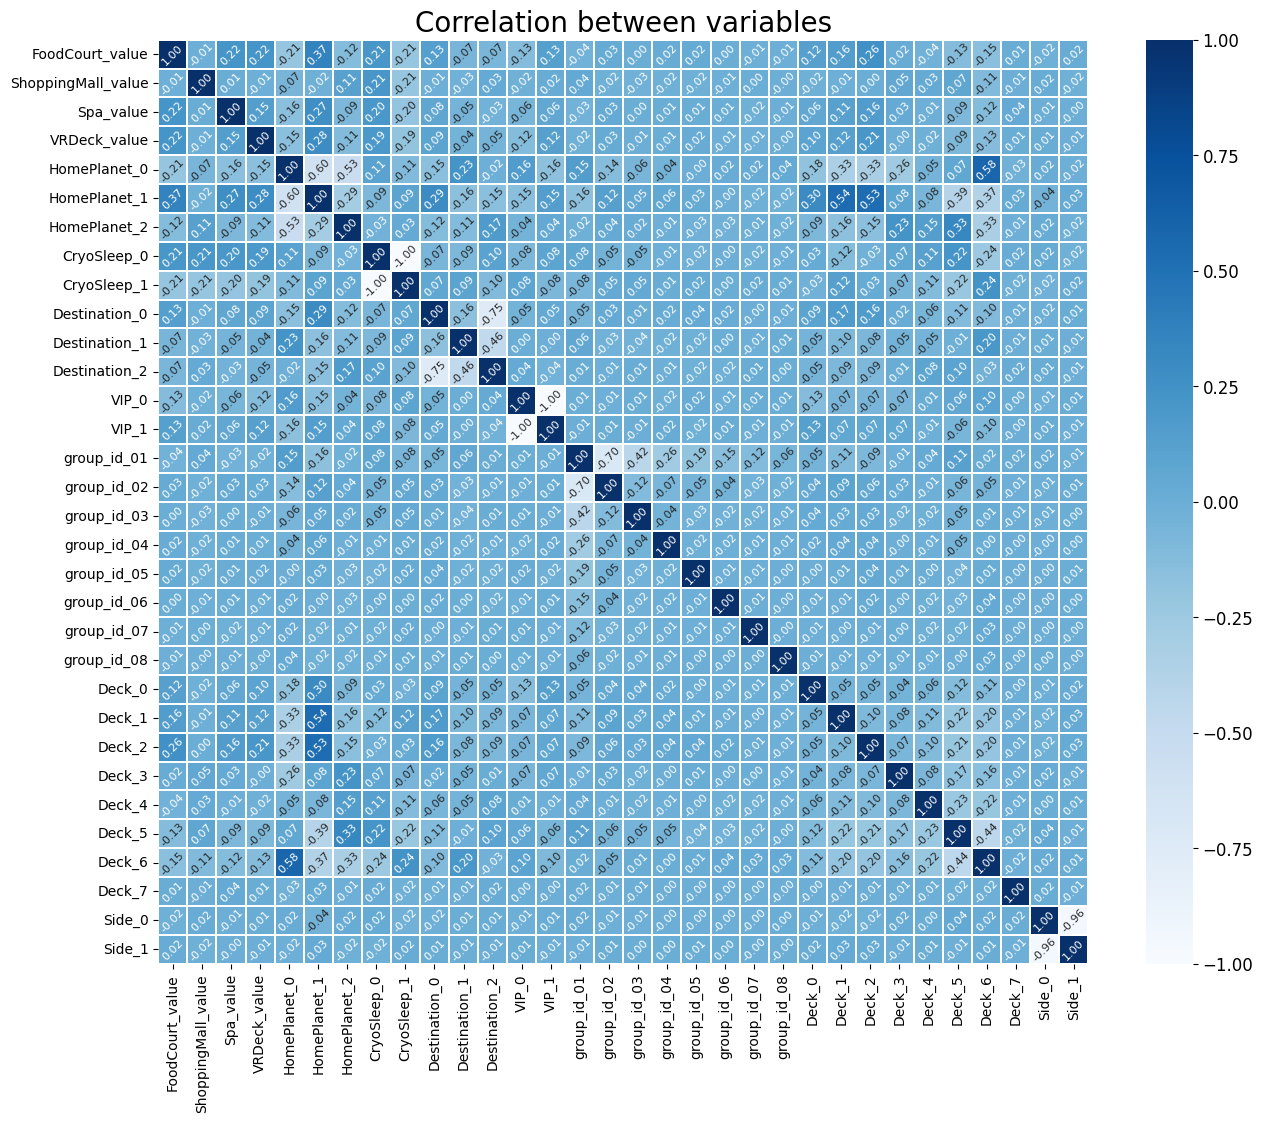

In [7]:
plt.figure(figsize=(15,12))
sns.heatmap(df.iloc[:,3:].corr(), linewidths=0.05, annot=True,
            annot_kws={'size': 8, 'rotation': 45}, fmt='.2f', cmap="Blues")
plt.xticks(fontsize=10), plt.yticks(fontsize=10)
plt.title("Correlation between variables", fontsize=20)
plt.show()

Some of the features don't appear to give us much insight so let's try and prune the set of data and see if it makes any difference compared to version 1. We'll drop the Group ID and Side features to see if it makes any diference.

In [8]:
#drop the unwanted columns
delete_df_columns = ['group_id_01', 'group_id_02', 'group_id_03', 'group_id_04', 'group_id_05', 'group_id_06', 'group_id_07', 'group_id_08', 'Side_0', 'Side_1']
df.drop(delete_df_columns, axis=1, inplace=True)

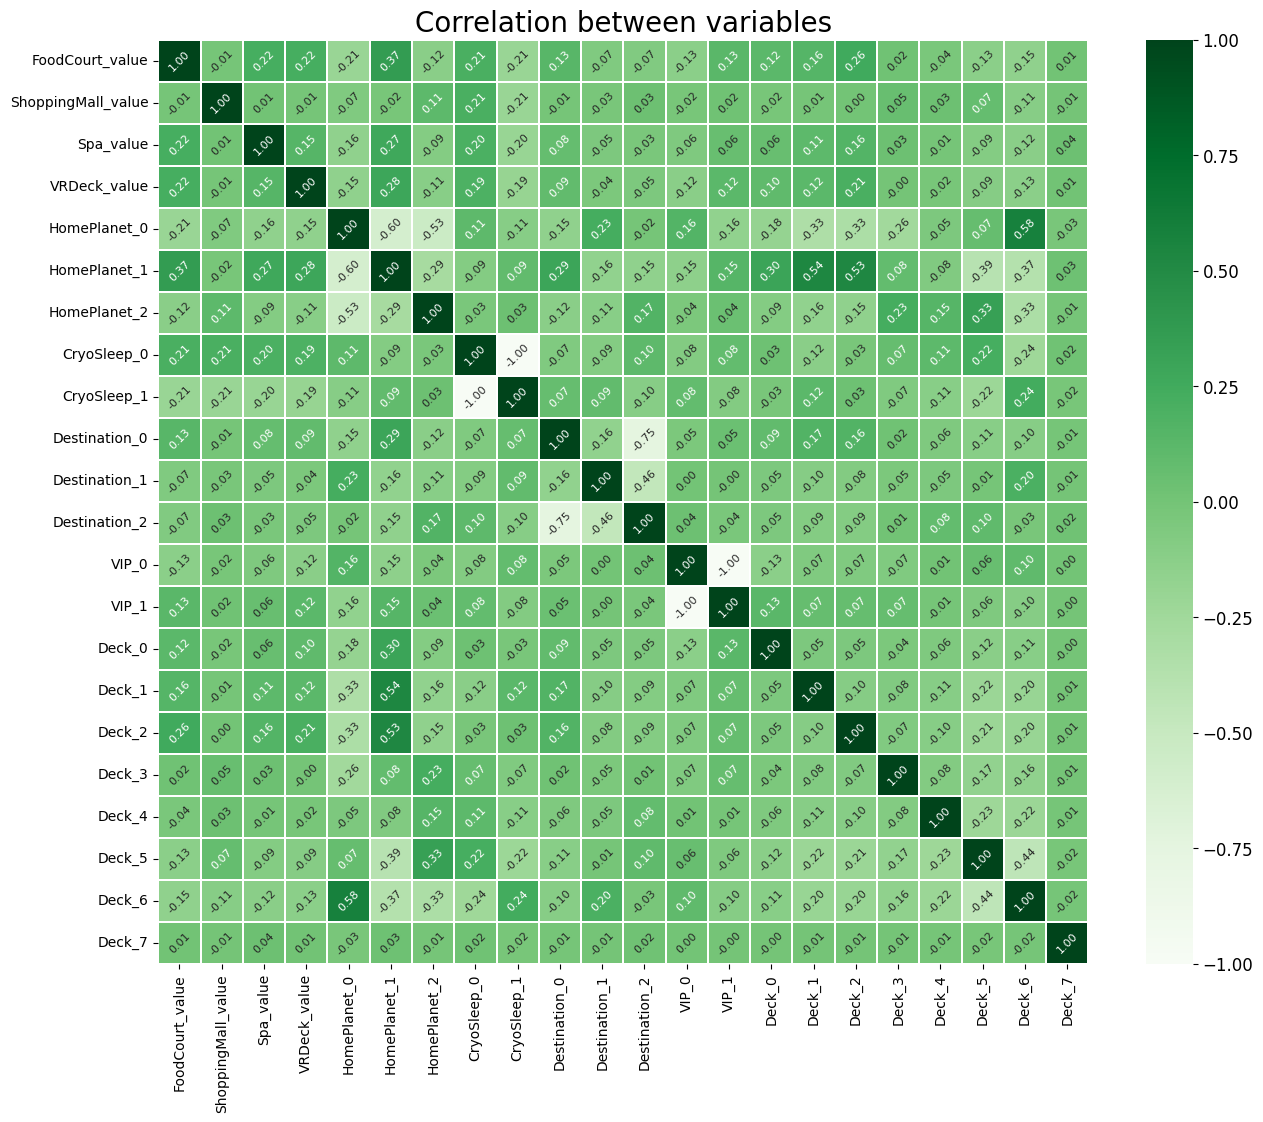

In [9]:
plt.figure(figsize=(15,12))
sns.heatmap(df.iloc[:,3:].corr(), linewidths=0.05, annot=True,
            annot_kws={'size': 8, 'rotation': 45}, fmt='.2f', cmap="Greens")
plt.xticks(fontsize=10), plt.yticks(fontsize=10)
plt.title("Correlation between variables", fontsize=20)
plt.show()

# Test some models

In [10]:
# Create train-validation splits
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [11]:
train = df.iloc[:8693, :].drop([], axis=1)
test = df.iloc[8693:, :].drop([], axis=1)
train.dropna(inplace=True)

In [12]:
y = train["Transported"]
X = train.drop(["Transported"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("test",len(df))

X_train 6519
X_test 2174
y_train 6519
y_test 2174
test 8693


In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(enable_categorical=True),
    'Gradient Boost' : GradientBoostingClassifier()
}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'{model_name}: Accuracy = {accuracy:.4f}')

Logistic Regression: Accuracy = 0.7626
Decision Tree: Accuracy = 0.7318
Random Forest: Accuracy = 0.7797
SVM: Accuracy = 0.7539
KNN: Accuracy = 0.7475
XGBoost: Accuracy = 0.7824
Gradient Boost: Accuracy = 0.7884


Compare this to what we got in v1:
```
Logistic Regression: Accuracy = 0.7613
Decision Tree: Accuracy = 0.7282
Random Forest: Accuracy = 0.7792
SVM: Accuracy = 0.7466
KNN: Accuracy = 0.7493
XGBoost: Accuracy = 0.7847
Gradient Boost: Accuracy = 0.7843
```

There is very little loss in accuracy.

In [14]:
gradient_boost = GradientBoostingClassifier(random_state=10).fit(X_train, y_train)
y_pred_catb = gradient_boost.predict(X_test)
accuracy_randf = accuracy_score(y_test, y_pred_catb)
print(f"accuracy: {accuracy_randf}")

accuracy: 0.7884084636614536


With all the group_id and Side features we got:
```
accuracy: 0.7842686292548298
````

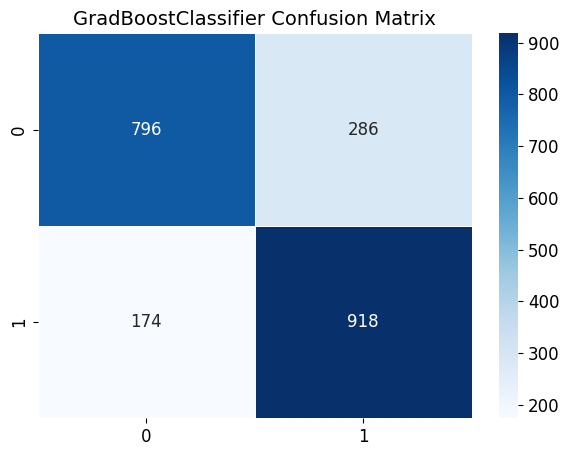

In [15]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_catb), annot=True, linewidths=0.6, cmap="Blues", fmt='.3g')
plt.title("GradBoostClassifier Confusion Matrix", fontsize=14)
plt.show()

Previously we got:
![v1](https://raw.githubusercontent.com/tudor-james/kaggle_playground/main/Screenshot%202024-04-10%20at%2010.53.42.png)

In [16]:
print(classification_report(y_test, y_pred_catb))

              precision    recall  f1-score   support

       False       0.82      0.74      0.78      1082
        True       0.76      0.84      0.80      1092

    accuracy                           0.79      2174
   macro avg       0.79      0.79      0.79      2174
weighted avg       0.79      0.79      0.79      2174



and before:
```
              precision    recall  f1-score   support

       False       0.82      0.73      0.77      1082
        True       0.76      0.84      0.80      1092

    accuracy                           0.78      2174
   macro avg       0.79      0.78      0.78      2174
weighted avg       0.79      0.78      0.78      2174
```

In [17]:
y_prob = gradient_boost.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

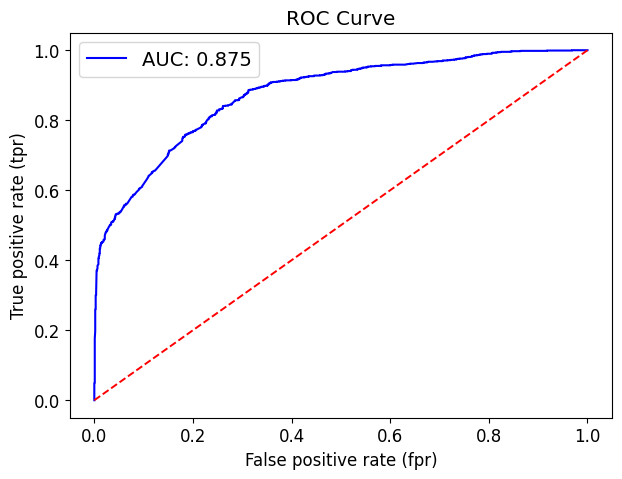

In [18]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color="blue", label= f"AUC: {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="r", linestyle="--", linewidth=1.4)
plt.legend(fontsize=14)
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.title("ROC Curve")
plt.show()

and before it was:
![v1_auc](https://github.com/tudor-james/kaggle_playground/blob/main/Screenshot%202024-04-10%20at%2010.54.12.png?raw=true)

In [19]:
# save model to file
pickle.dump(model, open("pima.pickle.dat", "wb"))

The CPU/memory metrics for just running the GradientBoost Model with the full dataset is 748.6MB vs. 736.5MB for the pruned model.


In [20]:
memory_use = 1-736.5/748.6
print(memory_use)

accuracy = 1-0.7842686292548298/0.7884084636614536
print(accuracy)

0.01616350520972487
0.0052508751458577585


# Conslusion

For this very small dataset we get a 1.6% improvement in memory consumption for reducing the model accuracy by 0.5%. These are small numbers but for large amounts of data these types of changes could have significant changes in the running costs of your applications. Preparing data is probably the most overlooked part of the application pipeline but it is critical that we build it in to our MLOps and FinOps pipelines and processes.